In [8]:
from multi_task.ablate_neurons import plot_prec_recall_change, reload_model, make_predictions, confusion_matrix, sort_neurons_for_class, calc_l1_norms_of_weights
from multi_task.util.dicts import imagenet_dict
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

import torch
import time
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set_context("paper")
from matplotlib.lines import Line2D

/mnt/antares_raid/home/spiess/projects/structure-for-interpretability/multi_task/util/util.py:21: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift
/tmp/ipykernel_31732/4095109376.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [9]:
usual_layer_idx_to_l1_norms_idx = { 0:'layer1.0.conv2.weight',
                                        1:'layer1.1.conv1.ordinary_conv.weight',
                                        2:'layer1.1.conv2.ordinary_conv.weight',
                                        3:'layer2.0.conv1.ordinary_conv.weight',
                                        4:'layer2.0.conv2.ordinary_conv.weight',
                                        5:'layer2.1.conv1.ordinary_conv.weight',
                                        6:'layer2.1.conv2.ordinary_conv.weight',
                                        7:'layer3.0.conv1.ordinary_conv.weight',
                                        8:'layer3.0.conv2.ordinary_conv.weight',
                                        9:'layer3.1.conv1.ordinary_conv.weight',
                                        10:'layer3.1.conv2.ordinary_conv.weight',
                                        11:'layer4.0.conv1.ordinary_conv.weight',
                                        12:'layer4.0.conv2.ordinary_conv.weight',
                                        13:'layer4.1.conv1.ordinary_conv.weight',
                                        14:'layer4.1.conv2.ordinary_conv.weight'}

In [21]:
def new_plot_prec_recall_change(save_model_path, param_file, metric_name,
                          # saved_activations_path='activations_on_validation_preserved_spatial_10_pretrained_imagenet.npy',
                          saved_activations_path='activations_on_validation_14_pretrained_imagenet.npy',
                            saved_labels_path='labels_pretrained_imagenet.npy', wd_path=None,
                            l1_norms=None, force_recalculation=False, storage_path="."):

    model = reload_model(save_model_path, param_file)
    print(saved_activations_path)
    # works for layers 10 & 14:
    # with open(saved_activations_path, 'rb') as f:
    #     loaded_activations = torch.tensor(pickle.load(f))
    # works for layer 6:
    loaded_activations = torch.tensor(np.load(saved_activations_path))

    labels = np.load(saved_labels_path)
    wasser_dists_values = list(np.load(wd_path, allow_pickle=True).item().values())
    # print('Attention! What I do to get last linear weights only works for the pretrained imagenet model')

    if 'pretrained_imagenet' in saved_activations_path:
        fc_weights = model.fc.weight.detach().cpu().numpy()

    layeri = int(saved_activations_path.split('_')[-3])

    y_pred = make_predictions(model, loaded_activations, layeri, if_disable=False)
    precision_before, recall_before, _, _ = precision_recall_fscore_support(labels, y_pred)

    cm = confusion_matrix(labels, y_pred)
    FP = cm.sum(axis=0) - np.diag(cm)  
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)

    tpr = np.nan_to_num(TP/(TP+FN))
    ppv = np.nan_to_num(TP/(TP+FP))

    assert (recall_before == tpr).all()
    assert (precision_before == ppv).all()

    fpr_before = FP/(FP+TN)


    n_neurons_dict = {
        6: 128, 
        10: 256, 
        14: 512
    }

    testing = False

    if not testing:
        ablate_neurons_config = {
            256: [8, 16, 32, 64, 128, 192],
            512: [16, 32, 64, 128, 256, 384],
            128: [4, 8, 16, 32, 64, 96], 
        }
    else:
        ablate_neurons_config = {
            256: [8, 16, 32],
            512: [16, 32, 64],
            128: [4, 8, 16], 
        }

    n_neurons = n_neurons_dict[layeri]
    assert n_neurons == loaded_activations.size()[1]
    
    n_classes = 1000 if not testing else 5

    n_neurons_to_disable = ablate_neurons_config[n_neurons]

    save_postfix = f'layer{layeri}_disabled_{"_".join(str(x) for x in n_neurons_to_disable)}'
    if n_classes == 1000:
        save_postfix += '_imagenet'
    elif n_classes == 10:
        save_postfix += '_cifar10'
    elif n_classes == 5:
        save_postfix += '_testing'
    else:
        raise Exception(f"Unknown n_classes: {n_classes}")

    # def change_2d_array_into_dict(arr, neuron_sorting_fun_names):
    #         means_dict = {}
    #         for i, n in enumerate(neuron_sorting_fun_names):
    #             means_dict[n] = arr[i, :]
    #         return means_dict

    def random_perm_lambda():
        permuted_neurons = np.random.permutation(n_neurons)
        return lambda a, b: permuted_neurons

    sorting_funs_list = [
        ('random 1', random_perm_lambda()),
        # ('random 2', random_perm_lambda()),
        # ('random 3', random_perm_lambda()),
        (f'argmax {metric_name}', lambda metric_values, idx: np.array(sort_neurons_for_class(metric_values, idx)[0][::-1])),
        (f'argmin {metric_name}', lambda metric_values, idx: sort_neurons_for_class(metric_values, idx)[0])
    ]

    # Don't compute this, because what the ablation wants to show is whether these neurons affect exitatory or inhibitory.
    
    # if layeri == 14:
    #     # This kind of dilutes the plot as this was already compared when correlation to gradients was computed.
    #     if 'pretrained_imagenet' in saved_activations_path:
    #         sorting_funs_list += [
    #             ('sort-readout-max', lambda _, idx: np.argsort(fc_weights[idx])[::-1]),
    #             ('sort-readout-min', lambda _, idx: np.argsort(fc_weights[idx])),
    #         ]
    # else:
    #     # why this strategy? This sort by smallest weight magnitude as a baseline for sparse networks. Not really relevant for us. Ignore it!
    #     sorting_funs_list += [
    #         ('sort-l1', lambda _, idx: np.argsort(l1_norms))# this is sort-l1 for non-last layers
    #     ]

    neuron_sorting_fun_names, neuron_sorting_funs = zip(*sorting_funs_list)

    try:
        precision_means_dict = np.load(f'{storage_path}/prec_means_dict{save_postfix}.npy', allow_pickle=True).item()
        recall_means_dict = np.load(f'{storage_path}/recall_means_dict{save_postfix}.npy', allow_pickle=True).item()
        precision_stds_dict = np.load(f'{storage_path}/prec_stds_dict{save_postfix}.npy', allow_pickle=True).item()
        recall_stds_dict = np.load(f'{storage_path}/recall_stds_dict{save_postfix}.npy', allow_pickle=True).item()
    
        raw_precision_changes_dict = np.load(f'{storage_path}/raw_precision_changes_dict{save_postfix}.npy', allow_pickle=True).item()
        raw_recall_changes_dict = np.load(f'{storage_path}/raw_recall_changes_dict{save_postfix}.npy', allow_pickle=True).item()

        raw_fpr_changes_dict = np.load(f'{storage_path}/raw_fpr_changes_dict{save_postfix}.npy', allow_pickle=True).item()
        
        # raw_precision_dict = np.load(f'raw_precision_dict{save_postfix}.npy', allow_pickle=True).item()
        # raw_recall_dict = np.load(f'raw_recall_dict{save_postfix}.npy', allow_pickle=True).item()
    except:
        precision_means_dict = {}
        recall_means_dict = {}
        precision_stds_dict = {}
        recall_stds_dict = {}
        raw_precision_changes_dict = {}
        raw_recall_changes_dict = {}

        raw_fpr_changes_dict = {}

        # raw_precision_dict = {}
        # raw_recall_dict = {}
        
        
        # precision_means = np.zeros((len(neuron_sorting_funs), len(n_neurons_to_disable)))
        # recall_means = np.zeros((len(neuron_sorting_funs), len(n_neurons_to_disable)))
        # precision_stds = np.zeros((len(neuron_sorting_funs), len(n_neurons_to_disable)))
        # recall_stds = np.zeros((len(neuron_sorting_funs), len(n_neurons_to_disable)))
    
    something_changed = False

    for (sorting_fun_name, sorting_fun) in zip(neuron_sorting_fun_names, neuron_sorting_funs):
        if not force_recalculation and sorting_fun_name in precision_means_dict:
            continue

        something_changed = True
        
        precision_means_dict[sorting_fun_name] = np.zeros(len(n_neurons_to_disable))
        recall_means_dict[sorting_fun_name] = np.zeros(len(n_neurons_to_disable))
        precision_stds_dict[sorting_fun_name] = np.zeros(len(n_neurons_to_disable))
        recall_stds_dict[sorting_fun_name] = np.zeros(len(n_neurons_to_disable))

        raw_precision_changes_dict[sorting_fun_name] = np.zeros((len(n_neurons_to_disable), n_classes))
        raw_recall_changes_dict[sorting_fun_name] = np.zeros((len(n_neurons_to_disable), n_classes))

        raw_fpr_changes_dict[sorting_fun_name] = np.zeros((len(n_neurons_to_disable), n_classes))

        # raw_precision_dict[sorting_fun_name] = np.zeros((len(n_neurons_to_disable), n_classes))
        # raw_recall_dict[sorting_fun_name] = np.zeros((len(n_neurons_to_disable), n_classes))

        for j, n_to_disable in enumerate(n_neurons_to_disable):
            print(f'{n_to_disable} disabled')
            p_diffs = []
            r_diffs = []
            fpr_diffs = []
            
            # ps = []
            # rs = []
            already_computed_dict = dict()

            for class_idx in range(n_classes):
                print(class_idx)
                st = time.time()
                cur_idx = list(sorting_fun(wasser_dists_values, class_idx)[:n_to_disable])
                sorted_cur_idx = tuple(np.sort(cur_idx))
                
                # x = loaded_activations.clone().cuda()
                # x[:, cur_idx] = 0
                # x = model.fc(x)
                # conf_matr = confusion_matrix(labels, torch.argmax(x, dim=1).detach().cpu().numpy())
                
                if (sorted_cur_idx in already_computed_dict):
                    p, r, fpr = already_computed_dict[sorted_cur_idx]
                else:
                    # don't recompute if ablations doesn't change
                    y_pred = make_predictions(model, loaded_activations, layeri, if_disable=True, disable_ind=cur_idx)
                    
                    cm = confusion_matrix(labels, y_pred)
                    FP = cm.sum(axis=0) - np.diag(cm)  
                    FN = cm.sum(axis=1) - np.diag(cm)
                    TP = np.diag(cm)
                    TN = cm.sum() - (FP + FN + TP)

                    tpr = np.nan_to_num(TP/(TP+FN))
                    ppv = np.nan_to_num(TP/(TP+FP))
                    fpr = FP/(FP+TN)

                    p, r, _, _ = precision_recall_fscore_support(labels, y_pred)

                    assert (r == tpr).all()
                    assert (p == ppv).all()

                    # p = np.nan_to_num(p)
                    already_computed_dict[sorted_cur_idx] = (p, r, fpr)
                
                p_diff = p[class_idx] - precision_before[class_idx]
                r_diff = r[class_idx] - recall_before[class_idx]
                fpr_diff = fpr[class_idx] - fpr_before[class_idx]
                p_diffs.append(p_diff)
                r_diffs.append(r_diff)
                fpr_diffs.append(fpr_diff)
                # ps.append(p[class_idx])
                # rs.append(r[class_idx])
                ed = time.time()
                print(f'time={ed - st}')

            precision_means_dict[sorting_fun_name][j] = np.mean(p_diffs)
            recall_means_dict[sorting_fun_name][j] = np.mean(r_diffs)
            precision_stds_dict[sorting_fun_name][j] = np.std(p_diffs)
            recall_stds_dict[sorting_fun_name][j] = np.std(r_diffs)

            raw_precision_changes_dict[sorting_fun_name][j] = p_diffs
            raw_recall_changes_dict[sorting_fun_name][j] = r_diffs

            raw_fpr_changes_dict[sorting_fun_name][j] = fpr_diffs

            # raw_precision_dict[sorting_fun_name][j] = ps
            # raw_recall_dict[sorting_fun_name][j] = rs

            # plt.rcParams.update({'font.size': 17})
            # proper_hist(np.array(p_diffs), bin_size=0.02)
            # plt.savefig('prec_change32_hist.png', format='png')
            # plt.show()

    if something_changed:
        np.save(f'{storage_path}/prec_means_dict{save_postfix}.npy', precision_means_dict)
        np.save(f'{storage_path}/recall_means_dict{save_postfix}.npy', recall_means_dict)
        np.save(f'{storage_path}/prec_stds_dict{save_postfix}.npy', precision_stds_dict)
        np.save(f'{storage_path}/recall_stds_dict{save_postfix}.npy', recall_stds_dict)
        np.save(f'{storage_path}/raw_precision_changes_dict{save_postfix}.npy', raw_precision_changes_dict)
        np.save(f'{storage_path}/raw_recall_changes_dict{save_postfix}.npy', raw_recall_changes_dict)

        np.save(f'{storage_path}/raw_fpr_changes_dict{save_postfix}.npy', raw_fpr_changes_dict)
        # np.save(f'raw_precision_dict{save_postfix}.npy', raw_precision_dict)
        # np.save(f'raw_recall_dict{save_postfix}.npy', raw_recall_dict)

    info = {'neuron_sorting_fun_names':neuron_sorting_fun_names, 'n_neurons_to_disable':n_neurons_to_disable}
    np.save(f'{storage_path}/info_{save_postfix}.npy', info)

    plt.title('Precision change')
    plt.xlabel('Units ablated')
    # plt.xscale('log')
    plt.xticks(n_neurons_to_disable)
    # plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    for n in neuron_sorting_fun_names:
        plt.errorbar(n_neurons_to_disable, precision_means_dict[n], yerr=precision_stds_dict[n],
                    label=n, capsize=5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'prec_change_{save_postfix}.png', format='png')
    plt.savefig(f'prec_change_{save_postfix}.svg', format='svg')
    plt.show()
    plt.close()

    plt.title('Recall change')
    plt.xlabel('Units ablated')
    # plt.xscale('log')
    plt.xticks(n_neurons_to_disable)
    # plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    for n in neuron_sorting_fun_names:
        plt.errorbar(n_neurons_to_disable, recall_means_dict[n], yerr=recall_stds_dict[n],
                     label=n, capsize=5)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'rec_change_{save_postfix}.png', format='png')
    plt.savefig(f'rec_change_{save_postfix}.svg', format='svg')
    plt.show()
    plt.close()

    # Full distribution plots

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    plt.title('Precision change')
    plt.xlabel('Units ablated')
    plt.xticks(n_neurons_to_disable)
    
    handles = []
    for (i, n) in enumerate(neuron_sorting_fun_names):
        plt.plot(n_neurons_to_disable, raw_precision_changes_dict[n], color=colors[i], linewidth=0.1, alpha=0.1)
        line = Line2D([0], [0], label=n, color=colors[i])
        handles += [line]
    plt.legend(handles=handles, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.2))
    # plt.tight_layout()
    plt.savefig(f'prec_change_full_distribution_{save_postfix}.png', format='png')
    plt.savefig(f'prec_change_full_distribution_{save_postfix}.svg', format='svg')
    plt.show()
    plt.close()

    plt.title('FPR change')
    plt.xlabel('Units ablated')
    plt.xticks(n_neurons_to_disable)
    
    handles = []
    for (i, n) in enumerate(neuron_sorting_fun_names):
        plt.plot(n_neurons_to_disable, raw_fpr_changes_dict[n], color=colors[i], linewidth=0.1, alpha=0.1)
        line = Line2D([0], [0], label=n, color=colors[i])
        handles += [line]
    plt.legend(handles=handles, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.2))
    # plt.tight_layout()
    plt.savefig(f'fpr_change_full_distribution_{save_postfix}.png', format='png')
    plt.savefig(f'fpr_change_full_distribution_{save_postfix}.svg', format='svg')
    plt.show()
    plt.close()

    plt.title('Recall change')
    plt.xlabel('Units ablated')
    plt.xticks(n_neurons_to_disable)
    
    handles = []
    for (i, n) in enumerate(neuron_sorting_fun_names):
        plt.plot(n_neurons_to_disable, raw_recall_changes_dict[n], color=colors[i], linewidth=0.1, alpha=0.1)
        line = Line2D([0], [0], label=n, color=colors[i])
        handles += [line]
    plt.legend(handles=handles, loc="upper center", ncol=5, bbox_to_anchor=(0.5, 1.2))
    # plt.tight_layout()
    plt.savefig(f'rec_change_full_distribution_{save_postfix}.png', format='png')
    plt.savefig(f'rec_change_full_distribution_{save_postfix}.svg', format='svg')
    plt.show()
    plt.close()

In [22]:
imagenet_dict_reversed = dict(zip(imagenet_dict.values(), imagenet_dict.keys()))
if_pretrained_imagenet = True

path_prefix = 'stored_activations/'
storage_path = "local_storage/ablation_cache/"

In [23]:
if if_pretrained_imagenet:
        model_name_short = 'pretrained_imagenet'
        save_model_path = 'dummy'
        param_file = 'dummy'

In [24]:
try:
    l1_norms_dict = np.load(f'l1_norms_{model_name_short}.npy', allow_pickle=True).item()
except:
    calc_l1_norms_of_weights(save_model_path)
    l1_norms_dict = np.load(f'l1_norms_{model_name_short}.npy', allow_pickle=True).item()

For last layer (14), there is no l1-norm because it's just a single weight. This is what is sorted by in readout-max (by largest weight) and readout-min (by lowest weight).

TODO: For simplicity, maybe call it argmax-l1 and argmin-l1 and do it for all layers.

Currently, just the means and stds are saved.

I wanted to check how a line plot with low opacity and width might look like.

Plot the absolute values of precision and recall or use the probabilities.

stored_activations/activations_on_validation_preserved_spatial_14_pretrained_imagenet.npy


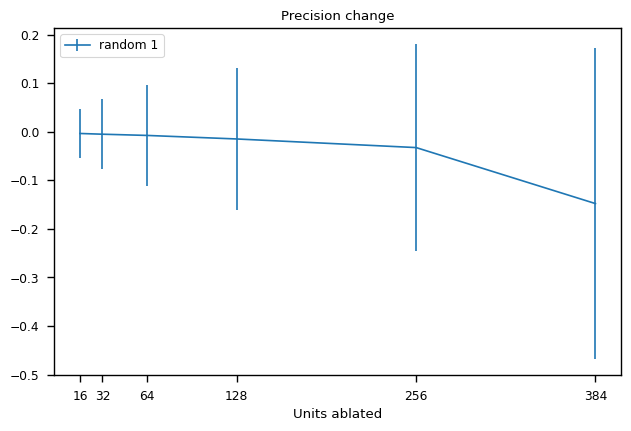

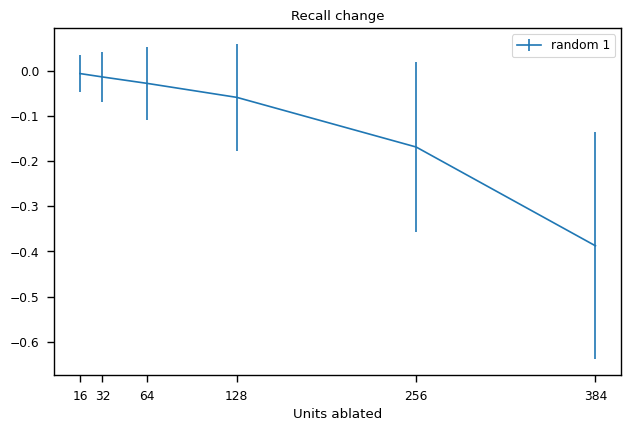

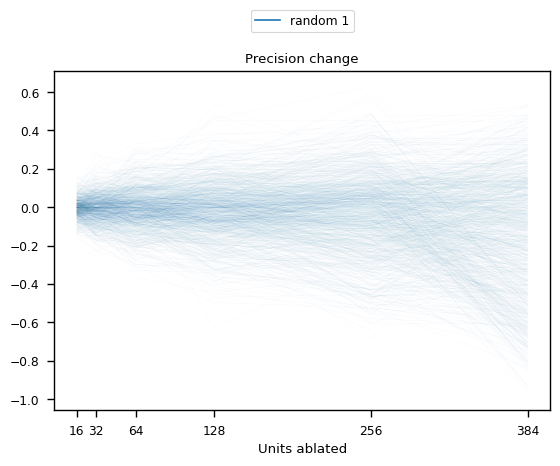

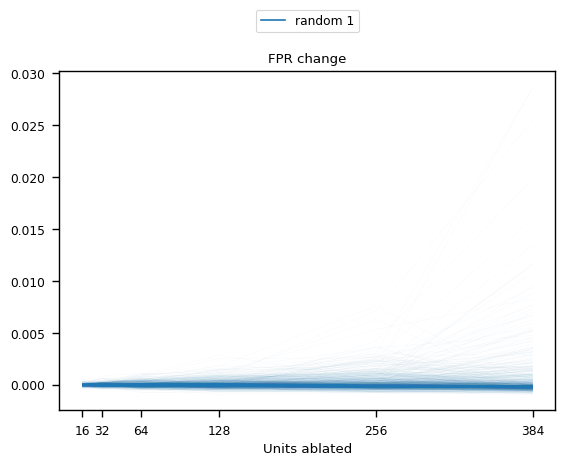

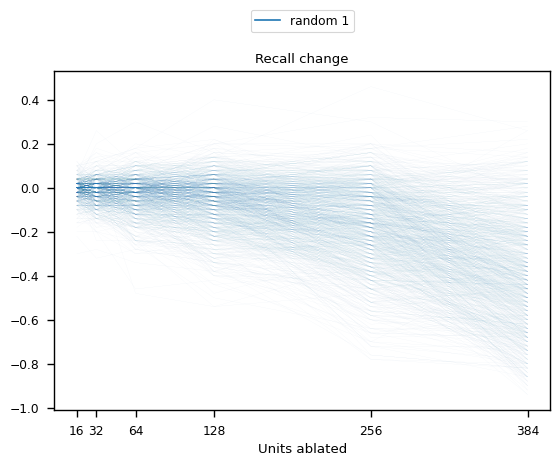

In [25]:
# Took 510 mins for layer 14

#TODO: for Cifar10 as well
for layeri in [6, 10, 14]:
        based_on = "_ks_diff"
        metric_name = "KS"
        # based_on = "_dist"
        
        new_plot_prec_recall_change(save_model_path, param_file, metric_name,
                                # saved_activations_path=f'activations_on_validation_{layeri}_pretrained_imagenet.npy',
                                saved_activations_path=f'{path_prefix}activations_on_validation_preserved_spatial_{layeri}_pretrained_imagenet.npy',
                                saved_labels_path='labels_pretrained_imagenet.npy',
                                wd_path=f'wasser_dists/wasser{based_on}_attr_hist_pretrained_imagenet_afterrelu_{layeri}.npy',
                                l1_norms=list(l1_norms_dict[usual_layer_idx_to_l1_norms_idx[layeri].replace('ordinary_conv.', '')].values()), force_recalculation=False, storage_path=storage_path)

Why precision increase for argmax: Because recall drops -> less samples are correct, but the others have higher precision

In [1]:
print("FINISHED!")
exit(0)

: 

In [124]:
save_postfix = 'layer14_disabled_16_32_64_128_256_384_imagenet'
n_neurons_to_disable = [16, 32, 64, 128, 256, 384]

raw_precision_changes_dict = np.load(f'raw_precision_changes_dict{save_postfix}.npy', allow_pickle=True).item()
raw_recall_changes_dict = np.load(f'raw_recall_changes_dict{save_postfix}.npy', allow_pickle=True).item()

raw_precision_dict = np.load(f'raw_precision_dict{save_postfix}.npy', allow_pickle=True).item()
raw_recall_dict = np.load(f'raw_recall_dict{save_postfix}.npy', allow_pickle=True).item()

In [125]:
raw_recall_dict['random'], raw_precision_dict['random']

(array([[0.9 , 0.82, 0.76, ..., 0.68, 0.5 , 0.38],
        [0.88, 0.76, 0.74, ..., 0.68, 0.54, 0.34],
        [0.9 , 0.74, 0.62, ..., 0.72, 0.56, 0.32],
        [0.9 , 0.76, 0.62, ..., 0.56, 0.48, 0.42],
        [0.92, 0.68, 0.3 , ..., 0.48, 0.4 , 0.26],
        [0.1 , 0.06, 0.62, ..., 0.18, 0.12, 0.12]]),
 array([[1.        , 0.87234043, 0.74509804, ..., 0.73913043, 0.51020408,
         0.63333333],
        [1.        , 0.92682927, 0.82222222, ..., 0.68      , 0.45      ,
         0.53125   ],
        [0.9375    , 0.97368421, 0.91176471, ..., 0.63157895, 0.4516129 ,
         0.53333333],
        [0.9       , 0.97435897, 0.91176471, ..., 0.71794872, 0.48979592,
         0.33333333],
        [0.77966102, 0.97142857, 0.9375    , ..., 0.68571429, 0.57142857,
         0.25490196],
        [1.        , 1.        , 0.56363636, ..., 0.9       , 0.46153846,
         0.35294118]]))

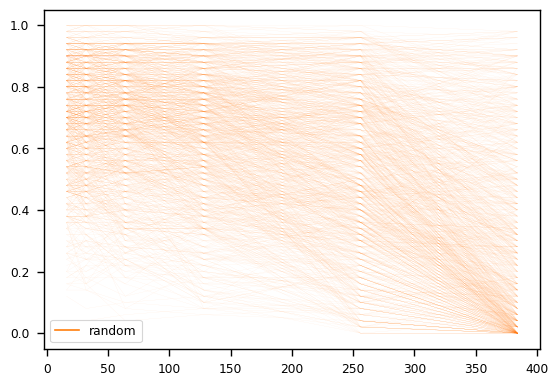

In [126]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.plot(n_neurons_to_disable, raw_recall_dict['random'], color=colors[1], linewidth=0.1, alpha=0.2);

line = Line2D([0], [0], label='random', color=colors[1])
handles = [line]

plt.legend(handles=handles)

In [73]:
raw_recall_changes_dict['random'][0]

array([ 0.02,  0.02,  0.  , -0.1 ,  0.  , -0.08,  0.08, -0.02,  0.  ,
        0.02,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.02,  0.  , -0.02,
        0.  ,  0.  ,  0.  ,  0.02,  0.  ,  0.02,  0.  ,  0.02, -0.08,
        0.02, -0.06, -0.04,  0.02,  0.  ,  0.  , -0.02, -0.06,  0.06,
       -0.08,  0.  ,  0.02,  0.04, -0.06,  0.04, -0.02,  0.02, -0.12,
        0.02,  0.  , -0.02, -0.02, -0.08,  0.02, -0.02,  0.02,  0.  ,
        0.  ,  0.  ,  0.  ,  0.02,  0.  , -0.04,  0.02,  0.02,  0.02,
       -0.02,  0.02, -0.02,  0.02,  0.  , -0.04, -0.02, -0.02, -0.06,
       -0.04,  0.  ,  0.02, -0.04,  0.  , -0.14,  0.  , -0.04,  0.  ,
        0.08, -0.04,  0.  ,  0.  ,  0.  ,  0.06, -0.02,  0.02,  0.  ,
        0.  , -0.04,  0.02,  0.02,  0.  ,  0.  ,  0.  ,  0.  , -0.02,
        0.  ,  0.  , -0.16,  0.  , -0.02, -0.04,  0.  , -0.04,  0.  ,
        0.  ,  0.02, -0.08, -0.02,  0.04,  0.  , -0.02,  0.02, -0.02,
       -0.02,  0.04,  0.04,  0.06, -0.02, -0.04, -0.06, -0.04, -0.02,
       -0.06,  0.  ,

In [98]:
saved_activations_path=f'{path_prefix}activations_on_validation_preserved_spatial_{layeri}_pretrained_imagenet.npy'

model = reload_model(save_model_path, param_file)
loaded_activations = torch.tensor(np.load(saved_activations_path))
layeri = int(saved_activations_path.split('_')[-3])
y_pred = make_predictions(model, loaded_activations, layeri, if_disable=False)

saved_labels_path = 'labels_pretrained_imagenet.npy'
labels = np.load(saved_labels_path)

In [99]:
prec, rec, _, _ = precision_recall_fscore_support(labels, y_pred)

In [101]:
rec, prec

(array([0.88, 0.82, 0.76, 0.7 , 0.84, 0.7 , 0.66, 0.76, 0.84, 0.94, 0.82,
        0.9 , 0.88, 1.  , 0.9 , 0.92, 0.88, 0.92, 0.88, 0.96, 0.8 , 0.76,
        0.92, 0.94, 0.96, 0.92, 0.66, 0.74, 0.84, 0.88, 0.82, 0.84, 0.4 ,
        0.76, 0.66, 0.68, 0.5 , 0.78, 0.7 , 0.7 , 0.62, 0.8 , 0.72, 0.78,
        0.62, 0.72, 0.44, 0.7 , 0.94, 0.64, 0.84, 0.86, 0.72, 0.76, 0.46,
        0.62, 0.78, 0.86, 0.66, 0.52, 0.32, 0.82, 0.34, 0.8 , 0.46, 0.64,
        0.48, 0.66, 0.22, 0.96, 0.76, 0.88, 0.86, 0.4 , 0.6 , 0.82, 0.94,
        0.74, 0.74, 0.68, 0.92, 0.8 , 0.82, 0.88, 0.86, 0.92, 0.68, 0.94,
        0.92, 0.86, 0.94, 0.84, 0.96, 0.8 , 0.94, 0.92, 0.84, 0.76, 0.84,
        0.7 , 0.94, 0.66, 0.98, 0.68, 0.82, 0.86, 0.74, 0.8 , 0.56, 0.86,
        0.74, 0.9 , 0.7 , 0.8 , 0.64, 0.82, 0.8 , 0.8 , 0.72, 0.56, 0.68,
        0.78, 0.72, 0.72, 0.5 , 0.76, 0.64, 0.88, 0.78, 0.96, 0.96, 0.9 ,
        0.9 , 0.88, 0.66, 0.96, 0.92, 0.92, 0.92, 0.96, 0.84, 0.86, 0.9 ,
        0.88, 0.9 , 0.9 , 0.94, 0.84, 

In [112]:
(y_pred[labels==123] == labels[labels==123]).sum()/((labels==123).sum())

0.72

In [116]:
rec[123], prec[123]

(0.72, 0.8181818181818182)

In [115]:
(y_pred[labels==123] == labels[labels==123]).sum()/((y_pred==123).sum())

0.8181818181818182

In [117]:
1/50

0.02